In [1]:
import sys
sys.path.append('./SimpleSMPLestX')

import torch

from utils.smplx_rendering import SMPLX_Video

In [2]:
model = torch.load("weights/smplest_x_h_inference.pth", weights_only=False)

model.cuda()
model.eval()


DataParallel(
  (module): Model(
    (encoder): ViT(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16), padding=(2, 2))
      )
      (blocks): ModuleList(
        (0): Block(
          (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
          (attn): Attention_ViT(
            (qkv): Linear(in_features=1280, out_features=3840, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1280, out_features=1280, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=1280, out_features=5120, bias=True)
            (act): GELU(approximate='none')
            (fc2): Linear(in_features=5120, out_features=1280, bias=True)
            (drop): Dropout(p=0.0, inplace=False)
          )
        )

In [3]:
import cv2
import torch
from models.person_detector import PersonDetectAndCrop

person_detector = PersonDetectAndCrop("weights/yolo11s.pt", "weights/detector_hands.pt")

In [4]:
vdo_path = "examples/test_video.mp4"

In [5]:
%%time
from tqdm.auto import tqdm
import time

cap = cv2.VideoCapture(vdo_path)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

frame_count = 0
detections = []

start_time = time.time()

with tqdm(total=total_frames) as pbar:
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Process detection for each frame
        person_pred = person_detector.predict(frame)
        detections.append(person_pred)
        
        frame_count += 1
        pbar.update(1)

end_time = time.time()
cap.release()

  0%|          | 0/298 [00:00<?, ?it/s]

CPU times: user 39 s, sys: 751 ms, total: 39.8 s
Wall time: 3.65 s


In [6]:
import numpy as np
import torch

# Convert list of param dicts to realigned numpy arrays
def realign_params(params_list):
    """
    Convert list of parameter dictionaries to stacked numpy arrays
    
    Args:
        params_list: List of dicts, each containing tensors of shape (1, ...)
    
    Returns:
        Dictionary with numpy arrays of shape (N, ...)
    """
    realigned_params = {}
    
    # Get all keys from first dictionary
    keys = params_list[0].keys()
    
    # Stack each parameter across all frames
    for key in keys:
        # Collect all tensors for this key
        tensors = [params[key] for params in params_list]
        
        # Stack along first dimension and convert to numpy
        realigned_params[key]  = torch.cat(tensors, dim=0)  
    
    return realigned_params

In [7]:
from scipy.signal import savgol_filter
params = []
with torch.no_grad():
    for d in tqdm(detections, desc="Generating video"):
        param = model(d[0]['person_crop'].cuda())
        params.append(param)

params = realign_params(params)

smooth_parts = ['smplx_body_pose']

for p in smooth_parts:
    poses = params[p].detach().cpu().numpy()
    smoothed_poses = savgol_filter(poses, 15, 3, axis=0)
    params[p] = torch.tensor(smoothed_poses).to('cuda')

Generating video:   0%|          | 0/298 [00:00<?, ?it/s]

In [8]:



renderer = SMPLX_Video(
    model_path='weights/smplx/SMPLX_FEMALE.npz',
    gender='FEMALE',
    device='cuda'
)


output_video_path = 'outputs/smplx_video.mp4'
# Generate video
success, last_frame = renderer.create_video(
    params=params,
    output_video_path=output_video_path,
    fps=25,
    resolution=(1024, 1024)
)

Rendering frames:   0%|          | 0/298 [00:00<?, ?it/s]

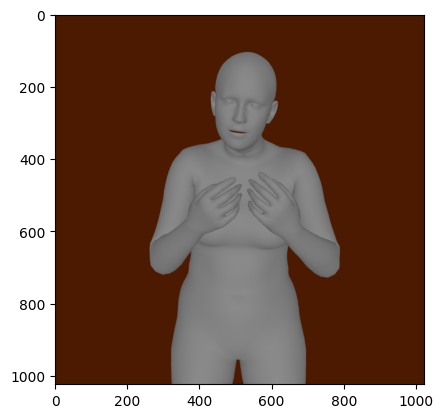

In [9]:
import matplotlib.pyplot as plt
plt.imshow(last_frame)

In [10]:
!ffmpeg -i {vdo_path} -i {output_video_path} -filter_complex "[0:v]crop=min(iw\,ih):min(iw\,ih),scale=1024:1024,drawtext=text='Original':fontcolor=white:fontsize=48:box=1:boxcolor=black@0.5:boxborderw=5:x=(w-text_w)/2:y=h-th-20[v0];[1:v]drawtext=text='SMPLest-X':fontcolor=white:fontsize=48:box=1:boxcolor=black@0.5:boxborderw=5:x=(w-text_w)/2:y=h-th-20[v1];[v0][v1]hstack=inputs=2[v]" -map "[v]" -c:v libx264 -crf 23 -pix_fmt yuv420p outputs/output_concatenated.mp4 -y

ffmpeg version 6.1.1-3ubuntu5 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 13 (Ubuntu 13.2.0-23ubuntu3)
  configuration: --prefix=/usr --extra-version=3ubuntu5 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --disable-omx --enable-gnutls --enable-libaom --enable-libass --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libharfbuzz --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-libzimg --ena